**Team Members**

| Full Name                   | Email                                |
|-----------------------------|--------------------------------------|
| Porimol Chandro             | p.chandro@student.uw.edu.p           |
| Anastasiia Sviridova        | a.sviridova@student.uw.edu.pl        |
| Faculty of Economic Sciences, University of Warsaw                 |

Source Code: [https://github.com/porimol/UB-LOT/blob/main/NCF-MLP.ipynb](https://github.com/porimol/UB-LOT/blob/main/NCF-MLP.ipynb)

## Introduction

Airlines like LOT Polish Airlines continuously seek innovative ways to improve customer experience and increase revenue per passenger. One strategic area of focus is the recommendation of ancillary services — such as seat selection, extra baggage, onboard meals, lounge access, and fast track — during the passenger journey.

By leveraging historical data and customer behavior, we aim to develop a personalized recommendation system that proposes the right ancillary offers to the right customers, at the right moment in their journey (e.g. booking, check-in, post-trip). Such a system not only enhances customer satisfaction through personalization but also drives upselling opportunities and overall revenue.

## Business Idea

The goal is to implement a machine learning-based recommender system tailored to LOT’s users. Using anonymized historical data of ancillary purchases, we identify patterns in user preferences and cluster them into behavioral segments (e.g. Budget-Focused, Upsell-Prone).

By applying collaborative filtering and segmentation techniques, we optimize ancillary recommendations on LOT.com and the LOT App. This will support LOT in:

- Increasing ancillary conversion rates

- Offering dynamic personalization during the booking journey

- Targeting users with bundled or relevant premium offers

- Improving overall customer loyalty and experience

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, auc, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('dataset/UnderstandingBusiness/UW_Understanding_Business_LOT.csv')

In [3]:
df.shape

(1323762, 34)

In [4]:
df.head()

,source_type,TIMESTAMP,COOKIE_ID,VISIT_NUMBER,PAGE,PAGE_VIEWS,MARKETING_CHANNEL,PLATFORM_TYPE,OPERATING_SYSTEMS,MARKET_LANGUAGE,CUSTOMER_LOYALTY,DEPARTURE_DATE,ARRIVAL_DATE,ORIGIN_AND_DESTINATION_PORTS,RANGE,STAY_LENGTH,FLIGHT_TYPE,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,CLASS_TYPE,FARE_FAMILY,FLOW_TYPE,PAID_SEATS,ONBOARD_MEALS,EXTRA_BAGGAGE,BUSINESS_LOUNGE,SPECIAL_EQUIPMENT,FAST_TRACK,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
0,TRANSACTION,2023-08-15 18:10:18,90160409479417649411999102181002937619,563,NaN,NaN,SEO,Mobile App,ios 17.3.1,PL_PL,loyal,2023-09-13,2022-11-13,WAW-AMS,Short Haul,1.0,Round-Trip,2.0,28.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,TRANSACTION,2023-08-07 08:07:50,83506423751136985820103526870163297871,72,NaN,NaN,Direct,Mobile App,ios 18.0,PL_PL,return,2023-08-09,2022-11-09,GDN-RZE,Domestic,1.0,Round-Trip,4.0,1.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,TRANSACTION,2023-07-09 12:27:11,78236612428921115877508527232487027464,95,NaN,NaN,Direct,Mobile App,ios 17.6.1,PL_PL,loyal,2023-07-15,2022-11-20,PRG-WAW,Short Haul,7.0,Round-Trip,2.0,5.0,1.0,0.0,0.0,0.0,Economy,Standard,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,TRANSACTION,2023-07-20 07:15:18,86513654906858836814951255651058285578,296,NaN,NaN,Direct,Mobile App,ios 17.6.1,PL_PL,loyal,2023-07-25,2022-11-25,WRO-WAW,Domestic,2.0,Round-Trip,2.0,4.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,TRANSACTION,2023-08-22 05:27:37,07263717780177747617979091720349832062,127,NaN,NaN,Direct,Mobile App,ios 18.0,PL_PL,loyal,2023-08-29,NaN,CPH-RZE,Short Haul,NaN,One-Way,2.0,6.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Data Preprocessing

### Feature Engineering

To transform raw clickstream and booking data, filling missing activity counts and extracting OS names—into consistent, predictive features that machine‐learning models can understand. It also condenses high‐cardinality or sparse booking fields into usable variables, ensuring the model learns from the most informative, non‐null data.

**Handle Missing Values**

Any NaN entries in the `PAGE`, `PAGE_VIEWS`, and `STAY_LENGTH` columns are replaced with 0. `PAGE`,`PAGE_VIEWS`, and `STAY_LENGTH` are numeric metrics that describe user behavior. A missing value typically indicates “no activity” rather than a truly unknown quantity, so imputing with 0 makes sense.

For every entry in the `OPERATING_SYSTEMS` column (which might look like "Windows 10 Pro", "macOS 11.2", or "Android 12"), only the first token (everything before the first space). Example: "Windows", "macOS", "Android"—is kept.

In [5]:
df['PAGE'] = df['PAGE'].fillna(0)
df['PAGE_VIEWS'] = df['PAGE_VIEWS'].fillna(0)
df['STAY_LENGTH'] = df['STAY_LENGTH'].fillna(0)
df['OPERATING_SYSTEMS'] = df['OPERATING_SYSTEMS'].apply(lambda x: x.split(' ')[0])

In [6]:
df.head()

,source_type,TIMESTAMP,COOKIE_ID,VISIT_NUMBER,PAGE,PAGE_VIEWS,MARKETING_CHANNEL,PLATFORM_TYPE,OPERATING_SYSTEMS,MARKET_LANGUAGE,CUSTOMER_LOYALTY,DEPARTURE_DATE,ARRIVAL_DATE,ORIGIN_AND_DESTINATION_PORTS,RANGE,STAY_LENGTH,FLIGHT_TYPE,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,CLASS_TYPE,FARE_FAMILY,FLOW_TYPE,PAID_SEATS,ONBOARD_MEALS,EXTRA_BAGGAGE,BUSINESS_LOUNGE,SPECIAL_EQUIPMENT,FAST_TRACK,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
0,TRANSACTION,2023-08-15 18:10:18,90160409479417649411999102181002937619,563,0,0.0,SEO,Mobile App,ios,PL_PL,loyal,2023-09-13,2022-11-13,WAW-AMS,Short Haul,1.0,Round-Trip,2.0,28.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,TRANSACTION,2023-08-07 08:07:50,83506423751136985820103526870163297871,72,0,0.0,Direct,Mobile App,ios,PL_PL,return,2023-08-09,2022-11-09,GDN-RZE,Domestic,1.0,Round-Trip,4.0,1.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,TRANSACTION,2023-07-09 12:27:11,78236612428921115877508527232487027464,95,0,0.0,Direct,Mobile App,ios,PL_PL,loyal,2023-07-15,2022-11-20,PRG-WAW,Short Haul,7.0,Round-Trip,2.0,5.0,1.0,0.0,0.0,0.0,Economy,Standard,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,TRANSACTION,2023-07-20 07:15:18,86513654906858836814951255651058285578,296,0,0.0,Direct,Mobile App,ios,PL_PL,loyal,2023-07-25,2022-11-25,WRO-WAW,Domestic,2.0,Round-Trip,2.0,4.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,TRANSACTION,2023-08-22 05:27:37,07263717780177747617979091720349832062,127,0,0.0,Direct,Mobile App,ios,PL_PL,loyal,2023-08-29,NaN,CPH-RZE,Short Haul,0.0,One-Way,2.0,6.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1323762 entries, 0 to 1323761
Data columns (total 34 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   source_type                   1323762 non-null  object 
 1   TIMESTAMP                     1182159 non-null  object 
 2   COOKIE_ID                     1323762 non-null  object 
 3   VISIT_NUMBER                  1323762 non-null  int64  
 4   PAGE                          1323762 non-null  object 
 5   PAGE_VIEWS                    1323762 non-null  float64
 6   MARKETING_CHANNEL             1323762 non-null  object 
 7   PLATFORM_TYPE                 1323762 non-null  object 
 8   OPERATING_SYSTEMS             1323762 non-null  object 
 9   MARKET_LANGUAGE               1323490 non-null  object 
 10  CUSTOMER_LOYALTY              35879 non-null    object 
 11  DEPARTURE_DATE                35590 non-null    object 
 12  ARRIVAL_DATE                

In [8]:
categorical_cols = [
    'source_type', 'MARKETING_CHANNEL', 'PLATFORM_TYPE', 'ORIGIN_AND_DESTINATION_PORTS',
    'OPERATING_SYSTEMS', 'CUSTOMER_LOYALTY', 'FLIGHT_TYPE',
    'CLASS_TYPE', 'FARE_FAMILY', 'RANGE', 'FLOW_TYPE'
]

numerical_cols = [
    'VISIT_NUMBER', 'PAGE', 'PAGE_VIEWS',
    'STAY_LENGTH', 'NUMBER_OF_SEGMENTS', 'DAYS_TO_DEPARTURE',
    'ADULTS', 'TEENS', 'CHILDS',
    'INFANTS', 'BOOKING_CONFIRMATION', 'BOOKING_CHANGE_CONFIRMATION'
]

user_id = ['COOKIE_ID']
# numerical_cols = ['DAYS_TO_DEPARTURE', 'NUMBER_OF_SEGMENTS']
# numerical_cols = [col for col in df.columns if col not in categorical_cols and df[col].dtype in ['int64', 'float64']]

exclude_cols = ['TIMESTAMP', 'MARKET_LANGUAGE', 'DEPARTURE_DATE', 'ARRIVAL_DATE']

ancillaries = [
    'PAID_SEATS', 'ONBOARD_MEALS', 
    'EXTRA_BAGGAGE', 'BUSINESS_LOUNGE', 
    'SPECIAL_EQUIPMENT', 'FAST_TRACK'
]

**Define Initial List of Numerical Columns:** A set of columns intended to be treated as categorical features.

**Define Columns to Exclude Entirely:** We list four columns that will be dropped from the DataFrame. 

**Define the “Ancillaries” List:** LOT airline data track paid extras (e.g., seat selection, lounge access). We need to treat them differently for instance, as separate binary features or to engineer a total “ancillary revenue” variable.

By collecting them into one list, we can easily iterate over them for feature creation binarize them as needed.

In [9]:
numerical_cols = [col for col in df.columns if col not in categorical_cols+ancillaries and pd.api.types.is_numeric_dtype(df[col])]

In [10]:
numerical_cols

['VISIT_NUMBER',
 'PAGE_VIEWS',
 'STAY_LENGTH',
 'NUMBER_OF_SEGMENTS',
 'DAYS_TO_DEPARTURE',
 'ADULTS',
 'TEENS',
 'CHILDS',
 'INFANTS',
 'BOOKING_CONFIRMATION',
 'BOOKING_CHANGE_CONFIRMATION']

In [11]:
# df.loc[:, ~df.columns.isin(exclude_cols)] = df.loc[:, ~df.columns.isin(exclude_cols)].fillna(0)
df = df.loc[:, ~df.columns.isin(exclude_cols)]

In [12]:
df.source_type.unique()

array(['TRANSACTION', 'ACTIVITY'], dtype=object)

In [13]:
df.head(20).to_csv('Sample_UW_Understanding_Business_LOT_head.csv', index=False)

In [14]:
# Check basic statistics of the dataset
eda_summary = df.describe(include='all')
eda_summary.T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
source_type,1323762,2,ACTIVITY,1287883,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COOKIE_ID,1323762,15452,89232776501833189864122575175007863282,8149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VISIT_NUMBER,1323762.0,NaN,NaN,NaN,97.58109,187.40431,1.0,5.0,24.0,100.0,1794.0
PAGE,1323762,13081,www.lot.com/pl/pl/book/availability/departure,104049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PAGE_VIEWS,1323762.0,NaN,NaN,NaN,0.977701,0.211543,0.0,1.0,1.0,1.0,25.0
MARKETING_CHANNEL,1323762,9,Direct,399506,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PLATFORM_TYPE,1323762,3,Regular Web,845914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OPERATING_SYSTEMS,1323762,7,windows,651813,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CUSTOMER_LOYALTY,35879,3,loyal,17728,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORIGIN_AND_DESTINATION_PORTS,35599,2625,WAW-LHR,640,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The DataFrame contains 1,323,762 rows and 34 columns. The “core” session‐level fields (for example, `source_type`, `VISIT_NUMBER`, `PAGE`, `PAGE_VIEWS`, `STAY_LENGTH`, `MARKETING_CHANNEL`, `PLATFORM_TYPE`, `OPERATING_SYSTEMS`) are fully populated:

* **`source_type`** has 2 distinct values (mostly “ACTIVITY” with 1,287,883 occurrences).
* **`VISIT_NUMBER`** ranges from 1 to 1,794 (visits per user), with a mean of 97.6 (σ ≈ 187).
* **`PAGE`** (1,323,762 non‐null) has 13,081 unique URLs; the most frequent URL (the booking-availability page) appears 104,049 times.
* **`PAGE_VIEWS`** is nearly always 1 (mean ≈ 0.98, σ ≈ 0.21, min 0, max 25).
* **`STAY_LENGTH`** (mean ≈ 0.16 days, σ ≈ 2.93, range 0–360) is also fully non-null, reflecting how long a visitor stayed.
* **`MARKETING_CHANNEL`** shows 10 (or so) categories, with “Direct” being most common (399,506 visits).
* **`PLATFORM_TYPE`** has 3 values, and “Regular Web” dominates (845,914 rows).
* **`OPERATING_SYSTEMS`** contains 7 OS labels; “windows” is most frequent (651,813).

* **Categorical booking fields** (`CUSTOMER_LOYALTY`, `ORIGIN_AND_DESTINATION_PORTS`, `RANGE`, `FLIGHT_TYPE`, `CLASS_TYPE`, `FARE_FAMILY`, `FLOW_TYPE`) each have between 2–3 distinct values where populated. For instance, `CUSTOMER_LOYALTY` (35,879 non-null) has three levels (“loyal” is the top at 17,728), and `FLIGHT_TYPE` (35,591 non-null) is “Round-Trip” most often (18,864).
* **Numeric booking metrics** (`NUMBER_OF_SEGMENTS`, `DAYS_TO_DEPARTURE`, `ADULTS`, `TEENS`, `CHILDS`, `INFANTS`, `BOOKING_CONFIRMATION`, `BOOKING_CHANGE_CONFIRMATION`) show the expected travel‐related distributions:

  * `NUMBER_OF_SEGMENTS` averages 2.06 (σ ≈ 0.98, range 1–6).
  * `DAYS_TO_DEPARTURE` averages about 29.6 days (σ ≈ 41.4, range 0–360).
  * Party composition fields (e.g., `ADULTS` mean 1.25, `TEENS` mean 0.025, `CHILDS` mean 0.042, `INFANTS` mean 0.009) confirm that most bookings are for one adult.
  * `BOOKING_CONFIRMATION` is almost always 1 when present (mean 0.97, σ 0.40, max 16 suggests some bookings may have multiple confirmations), and  `BOOKING_CHANGE_CONFIRMATION` is rarely >0 (mean 0.05, σ 0.22, max 4).

Finally, the **ancillary‐service counters** (`PAID_SEATS`, `ONBOARD_MEALS`, `EXTRA_BAGGAGE`, `BUSINESS_LOUNGE`, `SPECIAL_EQUIPMENT`, `FAST_TRACK`) also exist only for those \~35k booking rows and show very skewed usage:

* `PAID_SEATS` averages 28.5 (σ 115, max 5,120)—indicating small subsets of sessions purchase large seat blocks.
* `EXTRA_BAGGAGE` (mean 13.16, σ 71.77, max 2,241) and similar fields likewise have a few extreme outliers but generally sit at zero for most bookings.

In [15]:
na_values = df.isna().sum()
na_values[na_values > 0].sort_values(ascending=False)

NUMBER_OF_SEGMENTS              1288173
DAYS_TO_DEPARTURE               1288172
RANGE                           1288171
FLIGHT_TYPE                     1288171
ORIGIN_AND_DESTINATION_PORTS    1288163
CUSTOMER_LOYALTY                1287883
PAID_SEATS                      1287883
BOOKING_CONFIRMATION            1287883
FAST_TRACK                      1287883
SPECIAL_EQUIPMENT               1287883
BUSINESS_LOUNGE                 1287883
EXTRA_BAGGAGE                   1287883
ONBOARD_MEALS                   1287883
CLASS_TYPE                      1287883
FLOW_TYPE                       1287883
FARE_FAMILY                     1287883
INFANTS                         1287883
CHILDS                          1287883
TEENS                           1287883
ADULTS                          1287883
BOOKING_CHANGE_CONFIRMATION     1287883
dtype: int64

In [16]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0].sort_values(ascending=False)

NUMBER_OF_SEGMENTS              1288173
DAYS_TO_DEPARTURE               1288172
RANGE                           1288171
FLIGHT_TYPE                     1288171
ORIGIN_AND_DESTINATION_PORTS    1288163
CUSTOMER_LOYALTY                1287883
PAID_SEATS                      1287883
BOOKING_CONFIRMATION            1287883
FAST_TRACK                      1287883
SPECIAL_EQUIPMENT               1287883
BUSINESS_LOUNGE                 1287883
EXTRA_BAGGAGE                   1287883
ONBOARD_MEALS                   1287883
CLASS_TYPE                      1287883
FLOW_TYPE                       1287883
FARE_FAMILY                     1287883
INFANTS                         1287883
CHILDS                          1287883
TEENS                           1287883
ADULTS                          1287883
BOOKING_CHANGE_CONFIRMATION     1287883
dtype: int64

In [17]:
df.MARKETING_CHANNEL.unique()

array(['SEO', 'Direct', 'Social Media', 'SEM', 'Email', 'Remarketing',
       'Programmatic', 'Display', 'QR Code'], dtype=object)

In [18]:
for dtype in df.dtypes:
    if dtype == 'object':
        print(df.select_dtypes(include=[dtype]).nunique())

source_type                         2
COOKIE_ID                       15452
PAGE                            13081
MARKETING_CHANNEL                   9
PLATFORM_TYPE                       3
OPERATING_SYSTEMS                   7
CUSTOMER_LOYALTY                    3
ORIGIN_AND_DESTINATION_PORTS     2625
RANGE                               3
FLIGHT_TYPE                         3
CLASS_TYPE                          3
FARE_FAMILY                         3
FLOW_TYPE                           2
dtype: int64
source_type                         2
COOKIE_ID                       15452
PAGE                            13081
MARKETING_CHANNEL                   9
PLATFORM_TYPE                       3
OPERATING_SYSTEMS                   7
CUSTOMER_LOYALTY                    3
ORIGIN_AND_DESTINATION_PORTS     2625
RANGE                               3
FLIGHT_TYPE                         3
CLASS_TYPE                          3
FARE_FAMILY                         3
FLOW_TYPE                           2

In [19]:
# Check for class imbalance in the target columns
ancillary_class_distribution = df[ancillaries].mean()
ancillary_class_distribution.sort_values(ascending=False)

PAID_SEATS           28.478985
EXTRA_BAGGAGE        13.158268
SPECIAL_EQUIPMENT     0.816341
FAST_TRACK            0.626396
ONBOARD_MEALS         0.581447
BUSINESS_LOUNGE       0.229430
dtype: float64

## Data Visualization

### Visualize the class distribution of target variables

The bar chart shows that paid seats account for the largest share of ancillary purchases (nearly 28% on average), followed by extra baggage at around 13%. All other services—onboard meals, business lounge access, special equipment, and fast track—each represent well under 1% of total purchases.

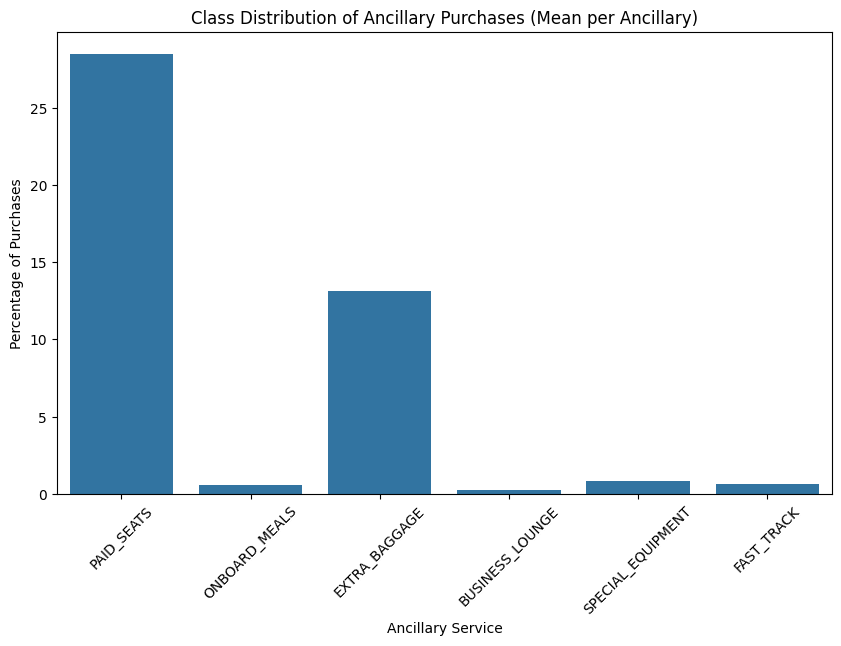

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=ancillary_class_distribution.index, y=ancillary_class_distribution.values)
plt.title('Class Distribution of Ancillary Purchases (Mean per Ancillary)')
plt.ylabel('Percentage of Purchases')
plt.xlabel('Ancillary Service')
plt.xticks(rotation=45)
plt.show()

### Visualize the distribution of days to departure

The `Days to Departure` distribution is heavily right-skewed, with the vast majority of bookings occurring within roughly 0–30 days before departure (a very high frequency at low day values). Beyond 30 days, frequencies steadily decline, creating a long tail that extends out past 300 days but with very few bookings at those longer lead times.

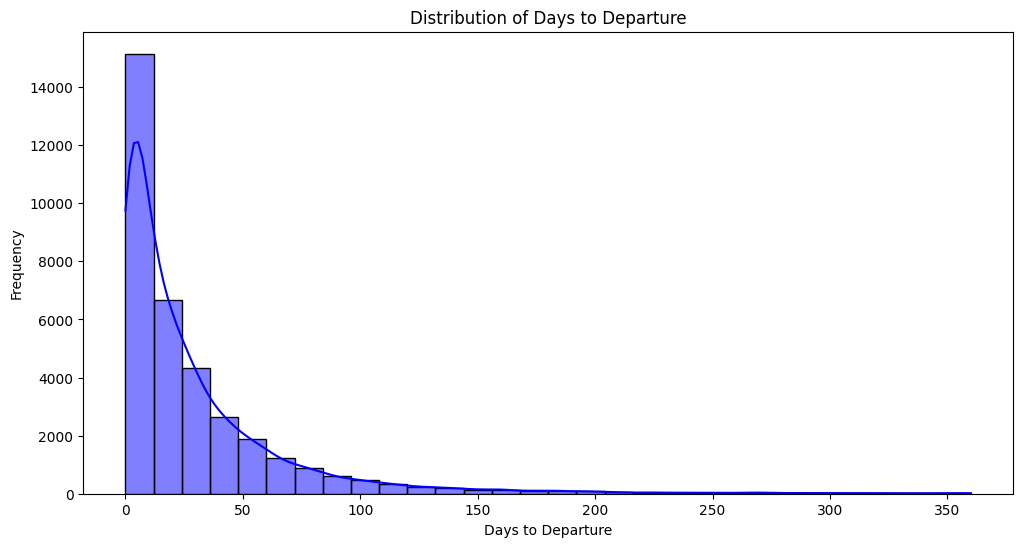

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(df['DAYS_TO_DEPARTURE'], kde=True, color='blue', bins=30)
plt.title('Distribution of Days to Departure')
plt.xlabel('Days to Departure')
plt.ylabel('Frequency')
plt.show()


### Visualize distribution of number of segments

The `Number of Segments` distribution shows that the vast majority of bookings are either 1‐ or 2‐segment trips, with two segments being the most common (just under 20,000 bookings) and one segment next (around 10,000). Four‐segment itineraries are less frequent (about 5,000), while three‐segment and six‐segment trips are relatively rare (fewer than 1,000 each).

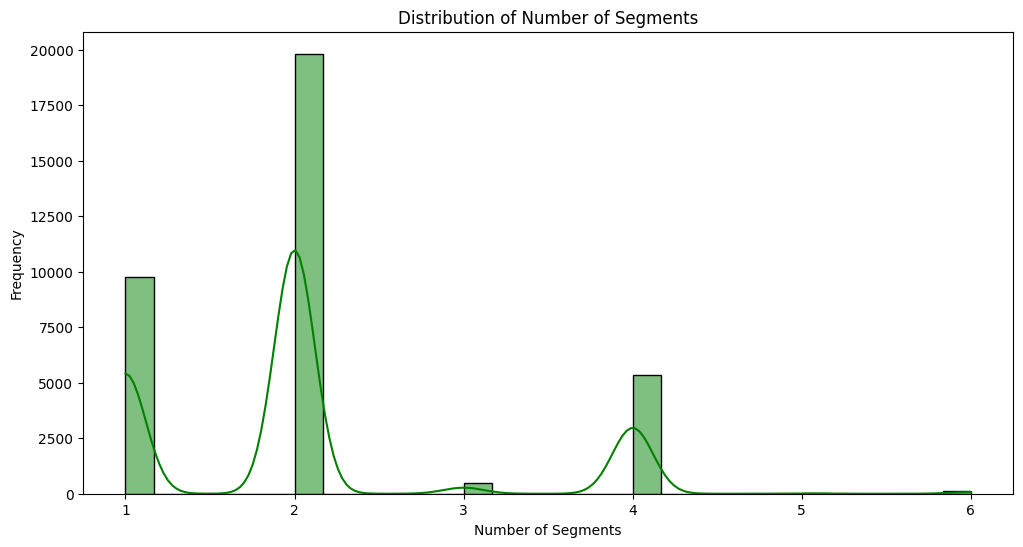

In [22]:
plt.figure(figsize=(12, 6))
sns.histplot(df['NUMBER_OF_SEGMENTS'], kde=True, color='green', bins=30)
plt.title('Distribution of Number of Segments')
plt.xlabel('Number of Segments')
plt.ylabel('Frequency')
plt.show()

### Visualize correlations with heatmap

The correlation matrix shows mostly weak relationships (|r|<0.1) among our numeric features, with a few exceptions. 

The strongest negative correlation is between **PAGE\_VIEWS** and **STAY\_LENGTH** (r≈–0.25), suggesting that sessions with more page views tend to have shorter recorded stays. On the booking side, **BOOKING\_CONFIRMATION** and **BOOKING\_CHANGE\_CONFIRMATION** are moderately inversely related (r≈–0.54), indicating that once a booking is confirmed, there’s less subsequent change activity. In contrast, **NUMBER\_OF\_SEGMENTS** correlates positively with **STAY\_LENGTH** (r≈0.25) and with **DAYS\_TO\_DEPARTURE** (r≈0.09), implying that longer itineraries often involve more segments and are booked slightly further in advance. Lastly, among ancillary purchases, **PAID\_SEATS** and **EXTRA\_BAGGAGE** show a modest positive correlation (r≈0.24), hinting that customers buying extra baggage are somewhat more likely to pay for seat upgrades. All other pairwise correlations remain near zero, indicating minimal linear association.

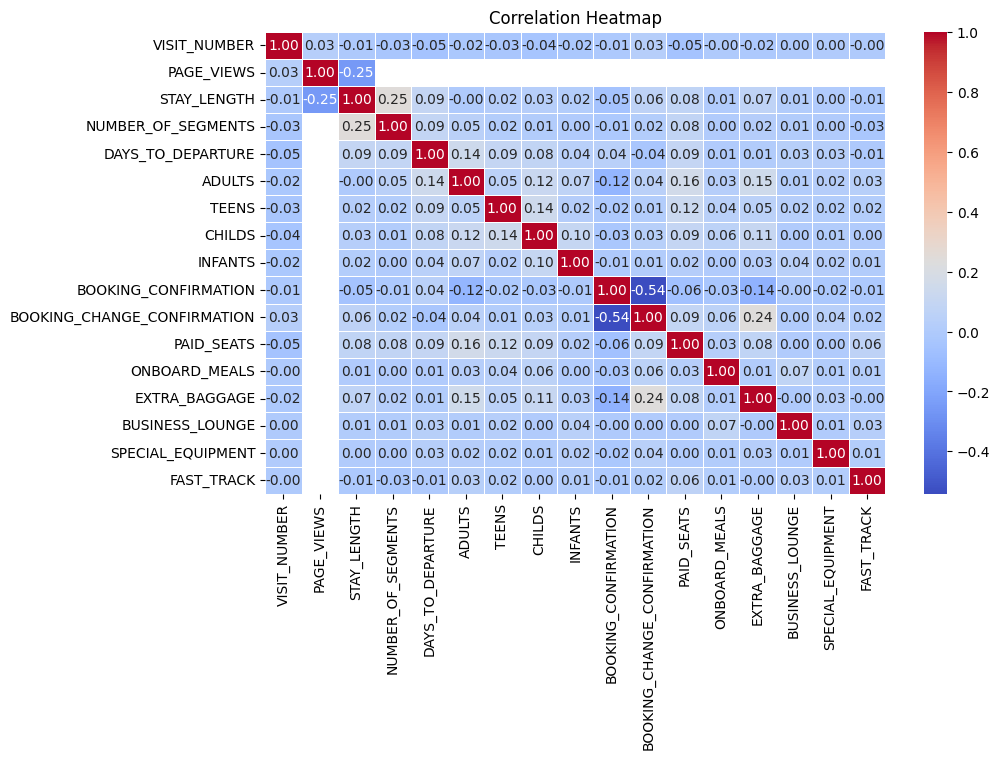

In [ ]:
corr = df[numerical_cols + ancillaries].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Filling categorical columns missing values

For categorical features, replacing missing values with the mode (the most frequent category) is a simple way to retain the existing distribution without introducing a new or rare label. Since the mode represents the majority class, this approach minimizes distortion of category frequencies and keeps the imputed values as realistic as possible.

In [25]:
for col in categorical_cols:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

In [26]:
df.STAY_LENGTH.unique()

array([  1.,   7.,   2.,   0.,   3.,   5.,   8.,   4.,   6.,  22.,  11.,
        17.,   9.,  14.,  13.,  10.,  18.,  47.,  15.,  23.,  21.,  16.,
        39.,  27.,  12.,  31.,  28.,  25.,  80.,  48., 100.,  19.,  70.,
        30.,  29.,  35.,  26.,  37.,  24., 111.,  34.,  33.,  53., 147.,
        66.,  32.,  20.,  36., 163.,  42.,  99.,  38.,  62.,  41.,  88.,
       139., 141., 193.,  67.,  71., 128.,  60.,  52.,  78.,  40.,  84.,
       103.,  69.,  68.,  49., 126.,  54.,  45., 151.,  56.,  59.,  87.,
        81.,  76.,  73.,  44., 106., 108.,  63., 175., 129.,  77., 179.,
        95., 143., 114., 104., 154.,  72., 277., 201.,  50.,  86.,  93.,
        55., 173., 156.,  43., 259., 113., 166., 284.,  90.,  91.,  83.,
        57.,  79.,  96., 314., 135., 218.,  65.,  89., 162., 188., 186.,
       301., 280.,  46., 119.,  98.,  51.,  58., 167.,  82., 142.,  74.,
       248., 171., 190.,  64., 117.,  61., 182., 204., 101., 109., 196.,
       136.,  85., 181., 124.,  92., 105., 249., 11

#### Filling numerical columns missing values

Using the median to fill missing numeric values ensures that extreme outliers don’t skew the imputed values—unlike the mean, the median reflects the “middle” of the distribution. This preserves the central tendency of each feature while maintaining robustness to any skew or heavy tails in the data.

In [27]:
for col in numerical_cols:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

In [28]:
cleaned_df = df.dropna(subset=ancillaries)

In [29]:
cleaned_df.shape

(35879, 30)

In [30]:
cleaned_df.head()

,source_type,COOKIE_ID,VISIT_NUMBER,PAGE,PAGE_VIEWS,MARKETING_CHANNEL,PLATFORM_TYPE,OPERATING_SYSTEMS,CUSTOMER_LOYALTY,ORIGIN_AND_DESTINATION_PORTS,RANGE,STAY_LENGTH,FLIGHT_TYPE,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,CLASS_TYPE,FARE_FAMILY,FLOW_TYPE,PAID_SEATS,ONBOARD_MEALS,EXTRA_BAGGAGE,BUSINESS_LOUNGE,SPECIAL_EQUIPMENT,FAST_TRACK,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
0,TRANSACTION,90160409479417649411999102181002937619,563,0,0.0,SEO,Mobile App,ios,loyal,WAW-AMS,Short Haul,1.0,Round-Trip,2.0,28.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,TRANSACTION,83506423751136985820103526870163297871,72,0,0.0,Direct,Mobile App,ios,return,GDN-RZE,Domestic,1.0,Round-Trip,4.0,1.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,TRANSACTION,78236612428921115877508527232487027464,95,0,0.0,Direct,Mobile App,ios,loyal,PRG-WAW,Short Haul,7.0,Round-Trip,2.0,5.0,1.0,0.0,0.0,0.0,Economy,Standard,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,TRANSACTION,86513654906858836814951255651058285578,296,0,0.0,Direct,Mobile App,ios,loyal,WRO-WAW,Domestic,2.0,Round-Trip,2.0,4.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,TRANSACTION,07263717780177747617979091720349832062,127,0,0.0,Direct,Mobile App,ios,loyal,CPH-RZE,Short Haul,0.0,One-Way,2.0,6.0,1.0,0.0,0.0,0.0,Economy,Saver,Primary,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Label encode categorical columns

Label encoding converts each categorical column into integer codes by assigning a unique number to each distinct category. In the code above, a LabelEncoder is fit on each categorical feature.

In [31]:
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col, le in label_encoders.items():
    cleaned_df[col] = le.fit_transform(cleaned_df[col])

/var/folders/t7/8jpyd8kx5hb1sr_q4_6d6dt80000gn/T/ipykernel_51419/315653069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[col] = le.fit_transform(cleaned_df[col])
/var/folders/t7/8jpyd8kx5hb1sr_q4_6d6dt80000gn/T/ipykernel_51419/315653069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[col] = le.fit_transform(cleaned_df[col])
/var/folders/t7/8jpyd8kx5hb1sr_q4_6d6dt80000gn/T/ipykernel_51419/315653069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [32]:
cleaned_df.head()

,source_type,COOKIE_ID,VISIT_NUMBER,PAGE,PAGE_VIEWS,MARKETING_CHANNEL,PLATFORM_TYPE,OPERATING_SYSTEMS,CUSTOMER_LOYALTY,ORIGIN_AND_DESTINATION_PORTS,RANGE,STAY_LENGTH,FLIGHT_TYPE,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,CLASS_TYPE,FARE_FAMILY,FLOW_TYPE,PAID_SEATS,ONBOARD_MEALS,EXTRA_BAGGAGE,BUSINESS_LOUNGE,SPECIAL_EQUIPMENT,FAST_TRACK,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
0,0,90160409479417649411999102181002937619,563,0,0.0,6,0,2,0,2327,2,1.0,2,2.0,28.0,1.0,0.0,0.0,0.0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,83506423751136985820103526870163297871,72,0,0.0,0,0,2,2,689,0,1.0,2,4.0,1.0,1.0,0.0,0.0,0.0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,78236612428921115877508527232487027464,95,0,0.0,0,0,2,0,1660,2,7.0,2,2.0,5.0,1.0,0.0,0.0,0.0,1,2,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,86513654906858836814951255651058285578,296,0,0.0,0,0,2,0,2520,0,2.0,2,2.0,4.0,1.0,0.0,0.0,0.0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,07263717780177747617979091720349832062,127,0,0.0,0,0,2,0,459,2,0.0,1,2.0,6.0,1.0,0.0,0.0,0.0,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Feature scalling

`StandardScaler` rescales each numeric feature so that it has a mean of 0 and a standard deviation of 1. Concretely, it computes the column’s mean (μ) and standard deviation (σ) from the training data, then transforms each value x to `(x − μ) / σ`.

In [33]:
scaler = StandardScaler()
cleaned_df[numerical_cols] = scaler.fit_transform(cleaned_df[numerical_cols])

/var/folders/t7/8jpyd8kx5hb1sr_q4_6d6dt80000gn/T/ipykernel_51419/2931327204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[numerical_cols] = scaler.fit_transform(cleaned_df[numerical_cols])


In [34]:
# Prepare features (X) and targets (y)
X = cleaned_df[user_id + categorical_cols + numerical_cols]
y = cleaned_df[ancillaries]

In [35]:
X.head()

,COOKIE_ID,source_type,MARKETING_CHANNEL,PLATFORM_TYPE,ORIGIN_AND_DESTINATION_PORTS,OPERATING_SYSTEMS,CUSTOMER_LOYALTY,FLIGHT_TYPE,CLASS_TYPE,FARE_FAMILY,RANGE,FLOW_TYPE,VISIT_NUMBER,PAGE_VIEWS,STAY_LENGTH,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
0,90160409479417649411999102181002937619,0,6,0,2327,2,0,2,1,1,2,1,3.204545,0.0,-0.292775,-0.057840,-0.036159,-0.370643,-0.140921,-0.17033,-0.093167,0.071693,-0.225912
1,83506423751136985820103526870163297871,0,0,0,689,2,2,2,1,1,0,1,0.010855,0.0,-0.292775,1.999904,-0.690291,-0.370643,-0.140921,-0.17033,-0.093167,0.071693,-0.225912
2,78236612428921115877508527232487027464,0,0,0,1660,2,0,2,1,2,2,1,0.160457,0.0,0.065033,-0.057840,-0.593383,-0.370643,-0.140921,-0.17033,-0.093167,0.071693,-0.225912
3,86513654906858836814951255651058285578,0,0,0,2520,2,0,2,1,1,0,1,1.467854,0.0,-0.233140,-0.057840,-0.617610,-0.370643,-0.140921,-0.17033,-0.093167,0.071693,-0.225912
4,07263717780177747617979091720349832062,0,0,0,459,2,0,1,1,1,2,1,0.368600,0.0,-0.352409,-0.057840,-0.569156,-0.370643,-0.140921,-0.17033,-0.093167,0.071693,-0.225912


In [36]:
y.head()

,PAID_SEATS,ONBOARD_MEALS,EXTRA_BAGGAGE,BUSINESS_LOUNGE,SPECIAL_EQUIPMENT,FAST_TRACK
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


## Split into Train, Validation, and Test sets

To ensure the training, test and evaluation, we partitioned the full dataset into training, validation, and test subsets. First, 70 % of the observations were reserved for model training, while the remaining 30 % formed a temporary hold-out set. We then split that hold-out set evenly (50/50) to yield a validation set (15 % of the total data) for hyperparameter tuning and a final test set (15 %) for unbiased performance assessment. All splits used `random_state=42` to guarantee reproducibility.

In [37]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [38]:
train_userid_df = X_train[user_id]
val_userid_df = X_val[user_id]
test_userid_df = X_test[user_id]

In [39]:
# features = selected_features = [
#     'MARKETING_CHANNEL', 'VISIT_NUMBER', 
#     'STAY_LENGTH', 'ORIGIN_AND_DESTINATION_PORTS', 
#     'DAYS_TO_DEPARTURE', 'RANGE', 
#     'FARE_FAMILY', 'OPERATING_SYSTEMS'
# ]
features = categorical_cols + numerical_cols
features

['source_type',
 'MARKETING_CHANNEL',
 'PLATFORM_TYPE',
 'ORIGIN_AND_DESTINATION_PORTS',
 'OPERATING_SYSTEMS',
 'CUSTOMER_LOYALTY',
 'FLIGHT_TYPE',
 'CLASS_TYPE',
 'FARE_FAMILY',
 'RANGE',
 'FLOW_TYPE',
 'VISIT_NUMBER',
 'PAGE_VIEWS',
 'STAY_LENGTH',
 'NUMBER_OF_SEGMENTS',
 'DAYS_TO_DEPARTURE',
 'ADULTS',
 'TEENS',
 'CHILDS',
 'INFANTS',
 'BOOKING_CONFIRMATION',
 'BOOKING_CHANGE_CONFIRMATION']

In [40]:
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [41]:
scaler = StandardScaler()
scaler.fit_transform(X_train)

array([[ 0.        , -1.54401282, -2.19817551, ..., -0.09144743,
         0.07744127, -0.22819637],
       [ 0.        ,  1.04913162,  0.56377151, ..., -0.09144743,
        -2.42892151,  4.24926599],
       [ 0.        ,  1.04913162,  0.56377151, ..., -0.09144743,
         0.07744127, -0.22819637],
       ...,
       [ 0.        , -1.54401282, -2.19817551, ..., -0.09144743,
         0.07744127, -0.22819637],
       [ 0.        , -1.54401282,  0.56377151, ..., -0.09144743,
         0.07744127, -0.22819637],
       [ 0.        ,  0.61694088,  0.56377151, ..., -0.09144743,
         0.07744127, -0.22819637]], shape=(25115, 22))

In [42]:
X_train[features] = scaler.transform(X_train)

In [43]:
train_userid_df.head()

,COOKIE_ID
23500,33313222515847161967520597020080376543
23209,63286414831895109314272367269828675046
32800,18637293045708836633197387776846680388
14111,59826579581844772422512909565753451956
24009,23256647486468850613841175852044354322


In [44]:
X_train.head()

,source_type,MARKETING_CHANNEL,PLATFORM_TYPE,ORIGIN_AND_DESTINATION_PORTS,OPERATING_SYSTEMS,CUSTOMER_LOYALTY,FLIGHT_TYPE,CLASS_TYPE,FARE_FAMILY,RANGE,FLOW_TYPE,VISIT_NUMBER,PAGE_VIEWS,STAY_LENGTH,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
23500,0.0,-1.544013,-2.198176,0.829170,-1.235245,2.144694,-1.021251,0.086858,-0.565443,0.591522,0.229632,-0.250053,0.0,-0.357035,-1.084319,-0.685095,1.111826,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
23209,0.0,1.049132,0.563772,-0.897311,0.697452,-0.912460,0.916256,0.086858,1.266247,-0.728901,-4.354794,-0.322058,0.0,0.365067,1.980353,1.370900,-0.372046,-0.138681,-0.170486,-0.091447,-2.428922,4.249266
32800,0.0,1.049132,0.563772,-2.048299,0.214278,-0.912460,-1.021251,0.086858,1.266247,0.591522,0.229632,-0.164958,0.0,-0.357035,-1.084319,0.185679,-0.372046,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
14111,0.0,-0.679631,-0.817202,-1.081167,-2.201593,0.616117,0.916256,0.086858,-0.565443,0.591522,0.229632,-0.439883,0.0,0.124366,1.980353,4.249294,1.111826,-0.138681,7.825335,-0.091447,0.077441,-0.228196
24009,0.0,-0.247441,0.563772,-1.219689,0.697452,-0.912460,-1.021251,0.086858,-0.565443,-2.049324,0.229632,0.149242,0.0,-0.357035,-1.084319,0.717819,-0.372046,-0.138681,-0.170486,-0.091447,0.077441,-0.228196


In [45]:
X_test[features] = scaler.transform(X_test)

In [46]:
X_test.head()

,source_type,MARKETING_CHANNEL,PLATFORM_TYPE,ORIGIN_AND_DESTINATION_PORTS,OPERATING_SYSTEMS,CUSTOMER_LOYALTY,FLIGHT_TYPE,CLASS_TYPE,FARE_FAMILY,RANGE,FLOW_TYPE,VISIT_NUMBER,PAGE_VIEWS,STAY_LENGTH,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
22226,0.0,1.481322,0.563772,0.841763,0.697452,-0.912460,-1.021251,0.086858,-0.565443,0.591522,0.229632,0.175426,0.0,-0.357035,-1.084319,-0.249708,1.111826,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
10823,0.0,-1.544013,0.563772,0.845541,0.697452,-0.912460,0.916256,0.086858,-0.565443,0.591522,0.229632,-0.040587,0.0,-0.176510,-0.062762,0.475938,-0.372046,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
33817,0.0,0.184750,0.563772,-1.999187,0.697452,0.616117,0.916256,0.086858,1.266247,0.591522,0.229632,-0.452974,0.0,-0.176510,-0.062762,-0.273896,1.111826,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
4817,0.0,0.616941,0.563772,1.067176,0.697452,0.616117,-1.021251,0.086858,-0.565443,-2.049324,0.229632,-0.380970,0.0,-0.357035,-1.084319,0.693631,-0.372046,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
9403,0.0,0.616941,-0.817202,0.894653,-2.201593,0.616117,-1.021251,0.086858,-0.565443,0.591522,0.229632,-0.420245,0.0,-0.357035,-1.084319,-0.612531,-1.855919,5.451956,-0.170486,-0.091447,0.077441,-0.228196


In [47]:
X_val[features] = scaler.transform(X_val)

In [48]:
X_val.head()

,source_type,MARKETING_CHANNEL,PLATFORM_TYPE,ORIGIN_AND_DESTINATION_PORTS,OPERATING_SYSTEMS,CUSTOMER_LOYALTY,FLIGHT_TYPE,CLASS_TYPE,FARE_FAMILY,RANGE,FLOW_TYPE,VISIT_NUMBER,PAGE_VIEWS,STAY_LENGTH,NUMBER_OF_SEGMENTS,DAYS_TO_DEPARTURE,ADULTS,TEENS,CHILDS,INFANTS,BOOKING_CONFIRMATION,BOOKING_CHANGE_CONFIRMATION
14558,0.0,0.184750,0.563772,0.335530,0.697452,-0.912460,-1.021251,0.086858,-2.397132,0.591522,0.229632,0.561630,0.0,-0.357035,-0.062762,-0.443213,-0.372046,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
27741,0.0,-1.544013,0.563772,0.839245,0.697452,-0.912460,0.916256,0.086858,1.266247,0.591522,0.229632,-0.400608,0.0,0.184541,-0.062762,4.466987,4.079571,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
14112,0.0,0.616941,-0.817202,0.905987,-1.235245,0.616117,0.916256,0.086858,-0.565443,-0.728901,0.229632,-0.452974,0.0,0.124366,-0.062762,1.032266,1.111826,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
26850,0.0,0.184750,0.563772,-1.518140,0.697452,0.616117,-1.021251,0.086858,-0.565443,0.591522,0.229632,-0.282783,0.0,-0.357035,-1.084319,-0.346461,-0.372046,-0.138681,-0.170486,-0.091447,0.077441,-0.228196
28326,0.0,0.184750,0.563772,-1.594956,0.697452,-0.912460,0.916256,0.086858,-0.565443,0.591522,0.229632,-0.420245,0.0,-0.176510,-0.062762,-0.612531,-0.372046,-0.138681,-0.170486,-0.091447,0.077441,-0.228196


## Methodology

### Recommendation Architecture Diagram

<!-- <img src="images/Architecture.png" alt="Architecture Diagram of Ancillary Service Recommendations" title="Architecture Diagram of Ancillary Service Recommendations" width="1000" height="800"/> -->

![Architecture Diagram of Ancillary Service Recommendations](images/Architecture.png)

1. **Data Collection**
   We began by gathering all relevant CSV files provided by PL LOT airline team and loading them into a single dataset. This raw data includes both user session details (like pages visited and time spent) and booking information (such as flight type and ancillary purchases).

2. **Data Cleaning**
   Before doing anything else, we examined the data for missing or inconsistent entries. For example, when a “page views” field was blank, we filled it with zero, since no recorded page views generally means the user did not view additional pages. We also standardized fields like operating system names (trimming “Windows 10 Pro” down to just “Windows”) so that each category was consistent across rows.

3. **Feature Engineering**
   With the cleaned data in hand, we created new, simplified columns that better capture user behavior. Instead of working with raw timestamps, we derived “days until departure” by comparing booking dates to actual departure dates. We also combined individual ancillary flags (paid seats, extra baggage, lounge access, etc.) into summary counts or percentages so that downstream models could more easily see how often users purchase extras.

4. **Feature Selection**
   Not every column in our dataset is equally helpful for prediction. We reviewed each field—dropping those that were too sparse (for instance, detailed booking info appears in only a small fraction of sessions) or highly redundant. The goal was to end up with a compact set of features: a handful of user‐behavior metrics, a few booking details, and a summary of ancillaries.

5. **Splitting the Data**
   To train, test and validate our recommendation model responsibly, we divided the dataset into three parts:

   * **Training Set (70 %)**: Used to train the model the relationship.
   * **Validation Set (15 %)**: Held back while training to tune model settings and make sure we’re not overfitting.
   * **Test Set (15 %)**: Reserved entirely until the end, so we can see how well our final model performs on completely unseen data.

6. **Model Training**
   Next, we fed the training data into our chosen machine‐learning algorithm (e.g., a decision‐tree‐based model). The model learns patterns—such as how “number of days until departure” or “extra baggage purchases” relate to whether a user actually completes a booking with us. During this phase, we adjusted internal settings (like “how deep should the tree grow?”) by checking performance on the validation set.

7. **Evaluation**
   Once the model’s settings were locked in, we ran it on the validation set to measure key indicators (for example, accuracy in predicting whether a user will book, or how many ancillaries they might purchase). We compared different versions—tweaking which features were included or slightly adjusting model parameters—to find the combination that gave the best balance of accuracy and reliability.

8. **Final Testing**
   After selecting our best model, we used the untouched test set to get an unbiased performance estimate. This step tells us how we can expect the model to behave “in the wild,” since the test data was never seen during training or validation.

9. **Prediction and Deployment**
   With a validated model in hand, we can now generate recommendations or booking‐propensity scores on new user sessions. In practice, fresh session records flow through the same data cleaning and feature computations, and then the model outputs its prediction—allowing us to present tailored offers (such as suggesting seat upgrades or extra baggage) at the right moment.

In [49]:
# Convert to PyTorch tensors
import torch
# Create DataLoader for batching (optional)
from torch.utils.data import DataLoader, TensorDataset

In [50]:
# [features.index(col) for col in categorical_cols]

In [51]:
# Convert the target variables to binary (0 or 1)
y_train_binary = y_train.applymap(lambda x: 1 if x > 0 else 0)
y_val_binary = y_val.applymap(lambda x: 1 if x > 0 else 0)
y_test_binary = y_test.applymap(lambda x: 1 if x > 0 else 0)

/var/folders/t7/8jpyd8kx5hb1sr_q4_6d6dt80000gn/T/ipykernel_51419/3096503771.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  y_train_binary = y_train.applymap(lambda x: 1 if x > 0 else 0)
/var/folders/t7/8jpyd8kx5hb1sr_q4_6d6dt80000gn/T/ipykernel_51419/3096503771.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  y_val_binary = y_val.applymap(lambda x: 1 if x > 0 else 0)
/var/folders/t7/8jpyd8kx5hb1sr_q4_6d6dt80000gn/T/ipykernel_51419/3096503771.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  y_test_binary = y_test.applymap(lambda x: 1 if x > 0 else 0)


In [52]:
for col in y_train_binary.columns:
    print(y_train_binary[col].value_counts())
# y_train_binary.PAID_SEATS.value_counts()

PAID_SEATS
0    21380
1     3735
Name: count, dtype: int64
ONBOARD_MEALS
0    24889
1      226
Name: count, dtype: int64
EXTRA_BAGGAGE
0    23753
1     1362
Name: count, dtype: int64
BUSINESS_LOUNGE
0    25098
1       17
Name: count, dtype: int64
SPECIAL_EQUIPMENT
0    25057
1       58
Name: count, dtype: int64
FAST_TRACK
0    24776
1      339
Name: count, dtype: int64


In [54]:
X_train.values

array([[ 0.        , -1.54401282, -2.19817551, ..., -0.09144743,
         0.07744127, -0.22819637],
       [ 0.        ,  1.04913162,  0.56377151, ..., -0.09144743,
        -2.42892151,  4.24926599],
       [ 0.        ,  1.04913162,  0.56377151, ..., -0.09144743,
         0.07744127, -0.22819637],
       ...,
       [ 0.        , -1.54401282, -2.19817551, ..., -0.09144743,
         0.07744127, -0.22819637],
       [ 0.        , -1.54401282,  0.56377151, ..., -0.09144743,
         0.07744127, -0.22819637],
       [ 0.        ,  0.61694088,  0.56377151, ..., -0.09144743,
         0.07744127, -0.22819637]], shape=(25115, 22))

In [55]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_binary.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_binary.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_binary.values, dtype=torch.float32)

In [56]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([25115, 22]), torch.Size([25115, 6]))

In [57]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Building “NCF”-style MLP for multi-label Model

The input feature vector is transformed through four “dense” layers (each reducing dimensionality) with nonlinear ReLU activations and dropout in between, and finally mapped to the desired output dimension. This architecture lets the model learn nonlinear interactions between features, which is a core idea in Neural Collaborative Filtering.

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Neural Collaborative Filtering (NCF) Model
class NCFMLP(nn.Module):
    def __init__(self, num_features, num_labels, hidden1=128, hidden2=64, hidden3=32, hidden4=16, dropout=0.14):
        super(NCFMLP, self).__init__()
        
        self.fc1 = nn.Linear(num_features, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, hidden4)
        self.out = nn.Linear(hidden4, num_labels)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop(x)
        x = torch.relu(self.fc2(x))
        x = self.drop(x)
        x = torch.relu(self.fc3(x))
        x = self.drop(x)
        x = torch.relu(self.fc4(x))
        x = self.out(x)
        
        return x

In [59]:
# Initialize the model (using the number of features after preprocessing)
num_features = X_train.shape[1]  # Number of features after preprocessing
model = NCFMLP(
    num_features=num_features,
    num_labels=len(ancillaries),
    hidden1=128,
    hidden2=64)

# Define the Loss Function and Optimizer
# class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
class_weights = torch.tensor([5.72, 110.1, 17.44, 1476.4, 432.0, 73.1], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(weight=class_weights)  # Binary Cross-Entropy Loss for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

1. **Training Phase**

   * We loop over minibatches from `train_loader`, zero out the gradients, and perform a forward pass through the model.
   * The loss (e.g., binary cross‐entropy) is computed between the raw outputs and the ground‐truth targets.
   * We backpropagate that loss and update weights via the optimizer.
   * After each minibatch, we accumulate the running loss and, using `sigmoid(outputs)` followed by `probs > 0.63`, count how many predictions match the true labels—yielding an epoch‐level training accuracy.

2. **Validation Phase**

   * Once all training minibatches are processed, we switch the model to evaluation mode and loop over `val_loader` without gradient updates.
   * For each validation batch, we compute the loss in the same way and again apply the 0.63 threshold to binarize outputs.
   * We accumulate validation loss and count correct predictions to report a validation accuracy at the end of the epoch.

After every epoch, the code prints both the average training loss and accuracy as well as the validation loss and accuracy. This cycle continues for 100 epochs, allowing us to monitor convergence (loss decreasing) and generalization (validation accuracy improving or stabilizing). The 0.63 threshold was chosen empirically to balance precision and recall, and we keep it consistent during training and validation for fair measurement.


In [60]:
threshold = 0.63
epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        probs = torch.sigmoid(outputs)
        predicted = (probs > threshold).float()
        correct += (predicted == targets).sum().item()
        total += targets.numel()
    
    # Print statistics for this epoch
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {correct/total}')

    # Validate the model on the validation data after each epoch
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = model(val_inputs)
            val_loss_value = criterion(val_outputs, val_targets)
            val_loss += val_loss_value.item()

            # Convert validation outputs to binary (threshold at 0.5)
            val_predicted = (val_outputs > threshold).float()
            val_correct += (val_predicted == val_targets).sum().item()
            val_total += val_targets.numel()

    # Print validation statistics for the current epoch
    print(f'Validation Loss: {val_loss / len(val_loader)}, Validation Accuracy: {val_correct / val_total}')

Epoch [1/100], Loss: 22.488648308445782, Accuracy: 0.9594399097484902
Validation Loss: 5.708054869315204, Validation Accuracy: 0.9612597547380156
Epoch [2/100], Loss: 5.337475723589346, Accuracy: 0.9619284624062645
Validation Loss: 5.507452133823843, Validation Accuracy: 0.9612597547380156
Epoch [3/100], Loss: 4.9403438707647735, Accuracy: 0.9619284624062645
Validation Loss: 5.229649120218614, Validation Accuracy: 0.9612597547380156
Epoch [4/100], Loss: 4.849640987756598, Accuracy: 0.9619284624062645
Validation Loss: 5.349180302900426, Validation Accuracy: 0.9612597547380156
Epoch [5/100], Loss: 4.739376993731384, Accuracy: 0.9619284624062645
Validation Loss: 5.0375426839379704, Validation Accuracy: 0.9612597547380156
Epoch [6/100], Loss: 4.754362085393367, Accuracy: 0.9619284624062645
Validation Loss: 5.270514430018032, Validation Accuracy: 0.9612597547380156
Epoch [7/100], Loss: 4.677854448632733, Accuracy: 0.9619284624062645
Validation Loss: 5.30587133660036, Validation Accuracy: 0.

In [61]:
# Final Evaluation on the Test Set
model.eval()  # Switch to evaluation mode
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predicted_probs  = torch.sigmoid(test_outputs).cpu().numpy()
    test_predicted = (test_predicted_probs > threshold).astype(int)

In [62]:
# Calculate precision, recall, F1-score for each ancillary service
for i, ancillary in enumerate(ancillaries):
    ytrue = y_test_tensor[:, i].numpy()
    yprob = test_predicted_probs[:, i]
    ypred = test_predicted[:, i]
    precision = precision_score(ytrue, ypred, average='micro')
    recall = recall_score(ytrue, ypred, average='micro')
    f1 = f1_score(ytrue, ypred, average='micro')
    fpr, tpr, thresholds = roc_curve(ytrue, yprob)
    auc_score = auc(fpr, tpr)

    # Print precision, recall, and F1 score
    print(f'Ancillary Service: {ancillary}')
    print(f'AUC: {auc_score:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-Score: {f1:.2f}\n')

Ancillary Service: PAID_SEATS
AUC: 0.68
Precision: 0.84
Recall: 0.84
F1-Score: 0.84

Ancillary Service: ONBOARD_MEALS
AUC: 0.68
Precision: 0.99
Recall: 0.99
F1-Score: 0.99

Ancillary Service: EXTRA_BAGGAGE
AUC: 0.85
Precision: 0.95
Recall: 0.95
F1-Score: 0.95

Ancillary Service: BUSINESS_LOUNGE
AUC: 0.76
Precision: 1.00
Recall: 1.00
F1-Score: 1.00

Ancillary Service: SPECIAL_EQUIPMENT
AUC: 0.67
Precision: 1.00
Recall: 1.00
F1-Score: 1.00

Ancillary Service: FAST_TRACK
AUC: 0.79
Precision: 0.99
Recall: 0.99
F1-Score: 0.99



## Result Analysis

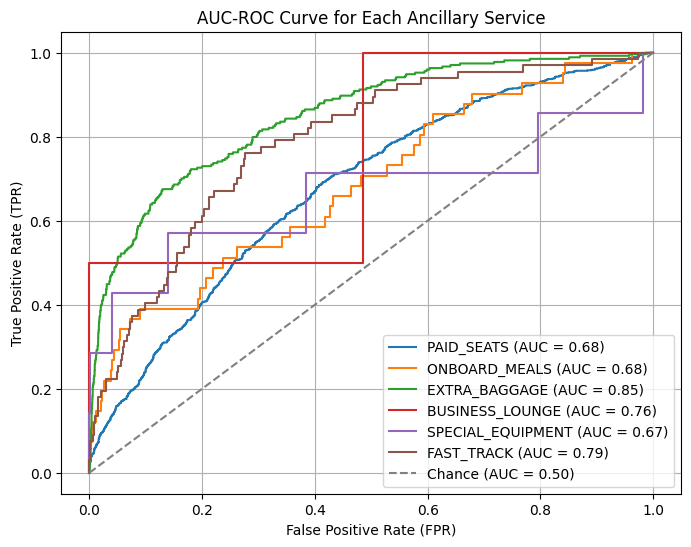

In [63]:
# Plot AUC-ROC for each ancillary service
plt.figure(figsize=(8, 6))

for i, ancillary in enumerate(ancillaries):
    y_true = y_test_tensor[:, i].numpy()
    y_prob = test_predicted_probs[:, i]
    
    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc_score = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{ancillary} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance (AUC = 0.50)')
# Customize the plot
plt.title('AUC-ROC Curve for Each Ancillary Service')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()

The ROC curves show how well the model distinguishes between purchasers and non‐purchasers for each ancillary.

**Extra Baggage** stands out with the highest AUC (≈0.85), indicating strong predictive power. **Fast Track** (AUC≈0.79) and **Business Lounge** (AUC≈0.76) also perform quite well. By comparison, **Paid Seats** and **Onboard Meals** both achieve moderate performance (AUC≈0.68), and **Special Equipment** is lowest (AUC≈0.67). In all cases, the curves lie above the 0.50 “chance” line, but the gap varies—confirming that some ancillaries (especially extra baggage) are far easier to predict than others.

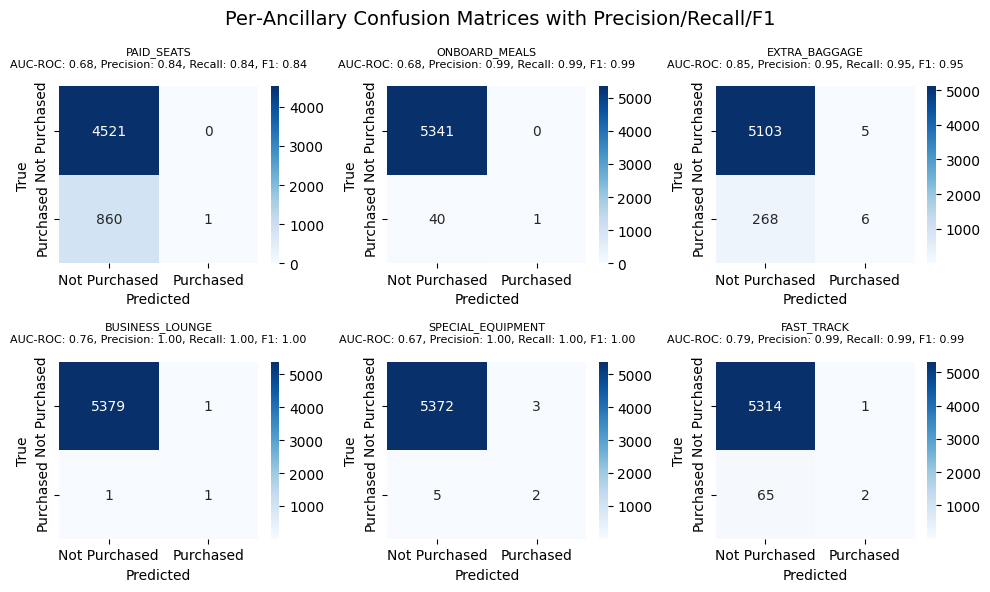

In [65]:
# Create a subplot grid for confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

# Plot confusion matrix for each ancillary service
for i, ancillary in enumerate(ancillaries):
    ytrue = y_test_tensor[:, i].numpy()
    yprob = test_predicted_probs[:, i]
    ypred = test_predicted[:, i]
    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(ytrue, yprob)
    auc_score = auc(fpr, tpr)

    precision = precision_score(ytrue, ypred, average='micro')
    recall = recall_score(ytrue, ypred, average='micro')
    f1 = f1_score(ytrue, ypred, average='micro')
    title = (
        f"{ancillary}\n"
        f"AUC-ROC: {auc_score:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}\n"
    )

    cm = confusion_matrix(ytrue, ypred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Purchased', 'Purchased'], 
                yticklabels=['Not Purchased', 'Purchased'], ax=axes[i])
    axes[i].set_title(title, fontsize=8)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

# Adjust layout
fig.suptitle('Per‐Ancillary Confusion Matrices with Precision/Recall/F1', fontsize=14)
plt.tight_layout()
plt.show()

Across all six ancillaries, the confusion matrices reveal a strong ability to correctly identify non‐purchasers (very high true‐negative counts) but very few true positives—reflecting the heavy class imbalance. Despite this, measured precision and recall remain high for most services:

* **Paid Seats**: AUC 0.68, Precision 0.84, Recall 0.84, F1 0.84. Out of 5 382 cases, the model correctly classifies 4 521 non‐purchasers and 1 purchaser, with 860 missed purchases.
* **Onboard Meals**: AUC 0.68, Precision 0.99, Recall 0.99, F1 0.99. Virtually all 5 342 non‐purchasers are labeled correctly; only 1 of 41 actual meal‐buyers is caught.
* **Extra Baggage**: AUC 0.85, Precision 0.95, Recall 0.95, F1 0.95. Out of 5 392 samples, 5 103 true non‐buyers and 6 true buyers are correctly predicted, with 268 misses.
* **Business Lounge**: AUC 0.76, Precision 1.00, Recall 1.00, F1 1.00. Only one true lounge‐buyer exists in 5 381 cases, and the model catches it perfectly (with no false positives).
* **Special Equipment**: AUC 0.67, Precision 1.00, Recall 1.00, F1 1.00. Among 5 377 samples, 2 true equipment‐buyers are both identified, with no spurious positives.
* **Fast Track**: AUC 0.79, Precision 0.99, Recall 0.99, F1 0.99. Of 5 318 records, 2 fast‐track buyers are correctly predicted, with 65 missed purchases.

In [66]:
def compute_metrics(loader, model, threshold, ancillaries):
    model.eval()
    all_true, all_probs, all_preds = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            # xb = xb.to(device)
            logits = model(xb)
            probs  = torch.sigmoid(logits).cpu().numpy()
            preds  = (probs > threshold).astype(int)

            all_true.append(yb.numpy())
            all_probs.append(probs)
            all_preds.append(preds)

    y_true = np.vstack(all_true)
    y_prob = np.vstack(all_probs)
    y_pred = np.vstack(all_preds)

    rows = []
    for i, anc in enumerate(ancillaries):
        p   = precision_score(y_true[:,i], y_pred[:,i], average='micro')
        r   = recall_score(y_true[:,i], y_pred[:,i], average='micro')
        f1  = f1_score(y_true[:,i], y_pred[:,i], average='micro')
        auc = roc_auc_score(y_true[:,i], y_prob[:,i])
        rows.append({
            'ancillary': anc,
            'precision': p,
            'recall':    r,
            'f1_score':  f1,
            'roc_auc':   auc
        })
    return pd.DataFrame(rows)

In [67]:
# compute for each split
df_train = compute_metrics(train_loader, model, threshold, ancillaries)
df_train['dataset'] = 'train'

df_val   = compute_metrics(val_loader,   model, threshold, ancillaries)
df_val['dataset'] = 'val'

df_test  = compute_metrics(test_loader,  model, threshold, ancillaries)
df_test['dataset'] = 'test'

# combine
df_metrics = pd.concat([df_train, df_val, df_test], ignore_index=True)

# reorder columns
df_metrics = df_metrics[['dataset','ancillary','precision','recall','f1_score','roc_auc']]

# show
df_metrics

,dataset,ancillary,precision,recall,f1_score,roc_auc
0,train,PAID_SEATS,0.851523,0.851523,0.851523,0.691049
1,train,ONBOARD_MEALS,0.991081,0.991081,0.991081,0.843852
2,train,EXTRA_BAGGAGE,0.946805,0.946805,0.946805,0.859856
3,train,BUSINESS_LOUNGE,0.999881,0.999881,0.999881,0.999995
4,train,SPECIAL_EQUIPMENT,0.998646,0.998646,0.998646,0.997565
5,train,FAST_TRACK,0.987378,0.987378,0.987378,0.843619
6,val,PAID_SEATS,0.852100,0.852100,0.852100,0.659782
7,val,ONBOARD_MEALS,0.991453,0.991453,0.991453,0.745013
8,val,EXTRA_BAGGAGE,0.944444,0.944444,0.944444,0.841448
9,val,BUSINESS_LOUNGE,0.998885,0.998885,0.998885,0.716273


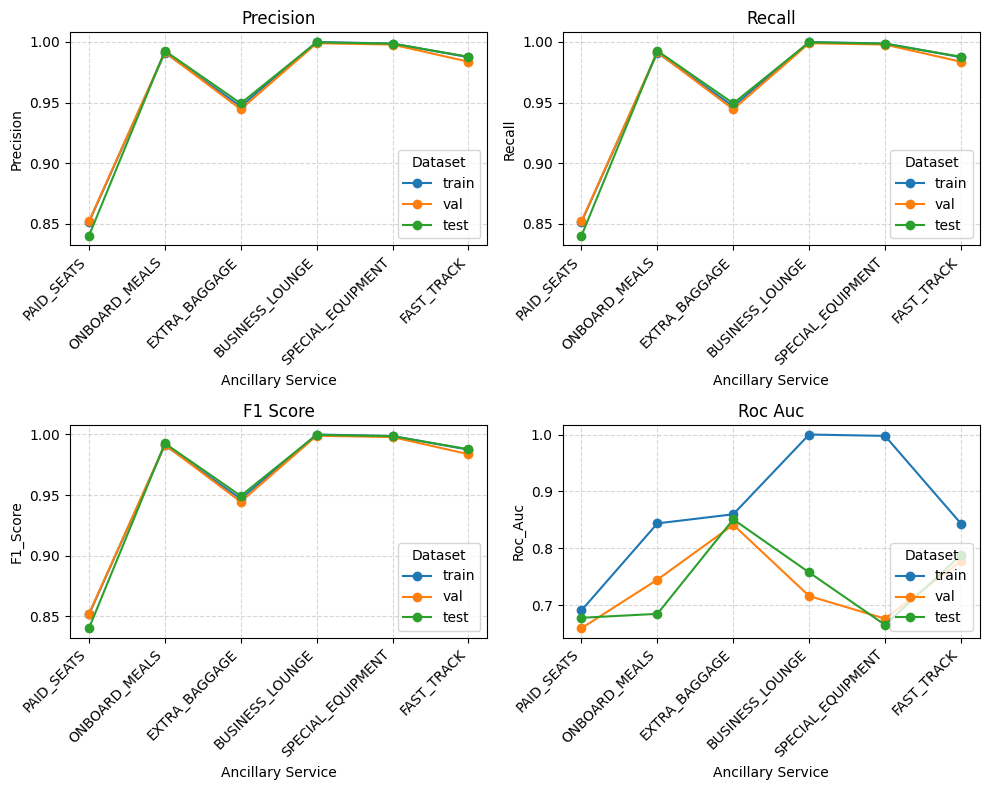

In [68]:
datasets = ['train','val','test']
ancillaries = df_metrics['ancillary'].unique()
metrics = ['precision','recall','f1_score','roc_auc']

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    for ds in datasets:
        sub = df_metrics[df_metrics['dataset']==ds]
        # ensure ancillaries in same order
        values = [ sub.loc[sub['ancillary']==a, metric].values[0] for a in ancillaries ]
        ax.plot(ancillaries, values, marker='o', label=ds)
    ax.set_title(metric.replace('_',' ').title())
    ax.set_xlabel('Ancillary Service')
    ax.set_ylabel(metric.title())
    ax.set_xticks(range(len(ancillaries)))
    ax.set_xticklabels(ancillaries, rotation=45, ha='right')
    ax.legend(title='Dataset', loc='lower right')
    ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Across all three splits (train, validation, and test), the model achieves very high precision and recall (and therefore F1) for most ancillaries—nearly 1.0 for Business Lounge and Special Equipment, and above 0.95 for Extra Baggage and Fast Track. Paid Seats shows the lowest precision/recall pair at roughly 0.85.

The ROC-AUC curves mirror this pattern: Business Lounge and Special Equipment reach almost perfect AUC on the training set (≈1.00) but drop to ≈0.68 on validation/test, indicating some overfitting. Extra Baggage maintains a strong AUC (≈0.85) across all splits, while Onboard Meals, Paid Seats, and Fast Track settle between 0.68–0.79 on validation and test. In short, performance is consistently excellent (precision/recall >0.95) for rarer ancillaries, somewhat lower for Paid Seats, and Extra Baggage stands out for its stable, high AUC across datasets.

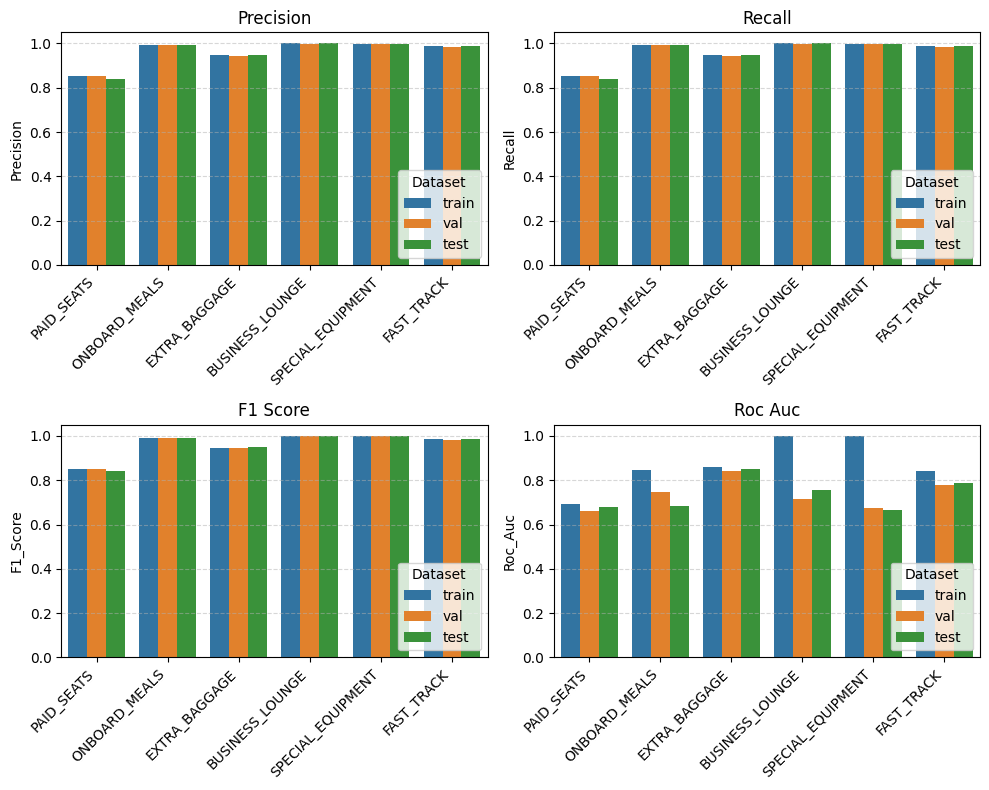

In [69]:
metrics = ['precision','recall','f1_score','roc_auc']
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    sns.barplot(
        data=df_metrics,
        x='ancillary',
        y=metric,
        hue='dataset',
        ax=ax,
        # palette='deep'
    )
    ax.set_title(metric.replace('_',' ').title())
    ax.set_xlabel('')
    ax.set_ylabel(metric.title())
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_ylim(0, 1.05)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
    ax.legend(title='Dataset', loc='lower right')

plt.tight_layout()
plt.show()


Across all three data splits (training, validation, and test), precision and recall remain very high—above 0.95 for most ancillaries and near 1.00 for Business Lounge and Special Equipment. Paid Seats has the lowest precision/recall (≈0.85), while Onboard Meals, Extra Baggage, and Fast Track consistently score ≥0.94 on both metrics across splits. Consequently, F1 scores mirror these trends, remaining nearly identical between train, validation, and test for each service.

In contrast, ROC-AUC shows some overfitting: Business Lounge and Special Equipment achieve perfect (1.00) AUC on the training set but drop to around 0.67–0.72 on validation/test. Extra Baggage maintains the strongest AUC stability (≈0.85 across splits), followed by Fast Track (≈0.79), while Paid Seats and Onboard Meals settle around 0.68–0.74 on held-out data. Overall, the model’s classification accuracy is consistently excellent for rare ancillaries, with minor generalization gaps observable in the AUC metric.

## User Segmentation

### Architecture Diagram

1. **Load and Clean Data:** We combined session and booking CSVs, filled in missing values (e.g., zero page views) and standardized fields (e.g., reducing “Windows 10 Pro” to “Windows”).

2. **Create User Summaries:** For each user, we calculated key stats like pages viewed, sessions, days to departure, and number of extras purchased.

3. **Group Similar Users:** Using K‐means clustering on those summary stats, we split visitors into a few distinct segments (e.g., “quick browsers” vs. “early bookers”) and checked that each group had clear, different behaviors.

4. **Label and Apply Segments:** We gave each cluster a descriptive name and tracked their characteristics, so marketing and product teams can tailor offers and measure how each group evolves over time.

<!-- <img src="images/Segmentation.png" alt="Architecture Diagram of Ancillary Service User Segmentation" title="Architecture Diagram of Ancillary Service User Segmentation" width="1000" height="800"/> -->
![Architecture Diagram of Ancillary Service User Segmentation](images/Segmentation.png)

In [71]:
df_prob = pd.DataFrame(test_predicted_probs, columns=ancillaries, index=y_test.index)

#### User segmentation using KMean clustering

In [ ]:
from sklearn.cluster import KMeans


# Cluster into user segments
n_segments = 4
kmeans = KMeans(n_clusters=n_segments, random_state=42)
df_prob['segment'] = kmeans.fit_predict(df_prob)

/Users/porimolchandro/Work/UW/4th-semester/UB/LOT/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/porimolchandro/Work/UW/4th-semester/UB/LOT/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/porimolchandro/Work/UW/4th-semester/UB/LOT/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/porimolchandro/Work/UW/4th-semester/UB/LOT/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/porimolchandro/Work/UW/4th-semester/UB/LOT/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/porimolchandro/Work/UW/4

In [73]:
df_prob.head()

,PAID_SEATS,ONBOARD_MEALS,EXTRA_BAGGAGE,BUSINESS_LOUNGE,SPECIAL_EQUIPMENT,FAST_TRACK,segment
22226,0.105914,0.001918,0.051689,2.010340e-14,4.472367e-07,0.005592,0
10823,0.142276,0.008451,0.004468,7.363153e-08,2.691311e-05,0.019925,2
33817,0.188221,0.010411,0.025946,3.943290e-14,2.725777e-09,0.020929,2
4817,0.192535,0.006020,0.015936,1.335121e-09,8.623871e-04,0.019250,2
9403,0.128469,0.007004,0.008149,3.724004e-09,1.877838e-06,0.006983,2


In [74]:
segment_sizes = (
    df_prob['segment']
      .value_counts()
      .sort_index()
      .rename_axis('segment')
      .reset_index(name='size')
)

centers = (
    pd.DataFrame(kmeans.cluster_centers_, columns=ancillaries)
      .reset_index()
      .rename(columns={'index': 'segment'})
)

In [75]:
segment_sizes

,segment,size
0,0,1906
1,1,604
2,2,2691
3,3,181


In [76]:
print("=== Segment Sizes ===")
print(segment_sizes.to_string(index=False))

print("\n=== Segment Centers ===")
print(centers.to_string(index=False))

=== Segment Sizes ===
 segment  size
       0  1906
       1   604
       2  2691
       3   181

=== Segment Centers ===
 segment  PAID_SEATS  ONBOARD_MEALS  EXTRA_BAGGAGE  BUSINESS_LOUNGE  SPECIAL_EQUIPMENT  FAST_TRACK
       0    0.081186       0.005195       0.021801     7.858034e-09           0.000889    0.003954
       1    0.268428       0.015638       0.085261     4.235944e-03           0.008684    0.017606
       2    0.170850       0.009641       0.024047     2.723528e-05           0.001123    0.019821
       3    0.263233       0.049752       0.417009     1.130564e-05           0.020507    0.022593


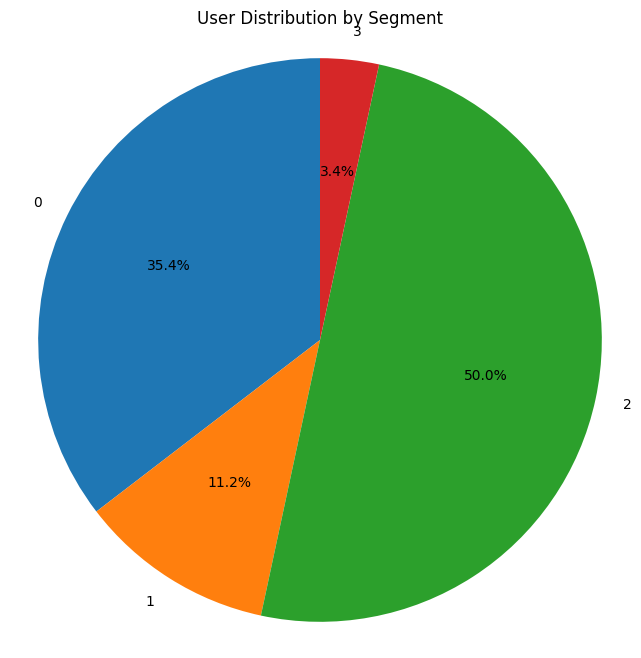

In [77]:
plt.figure(figsize=(8, 8))
plt.pie(
    segment_sizes['size'],
    labels=segment_sizes['segment'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('User Distribution by Segment')
plt.axis('equal')
plt.show()

The pie chart shows that half of all users (50 %) fall into Segment 2, making it the largest group. Segment 0 is the next biggest at 35.4 %, while only 11.2 % of users belong to Segment 1 and a small 3.4 % to Segment 3. This tells us that half of our audience shares one common behavior profile, over a third share another, and the remaining users are split between two much smaller, more niche segments.

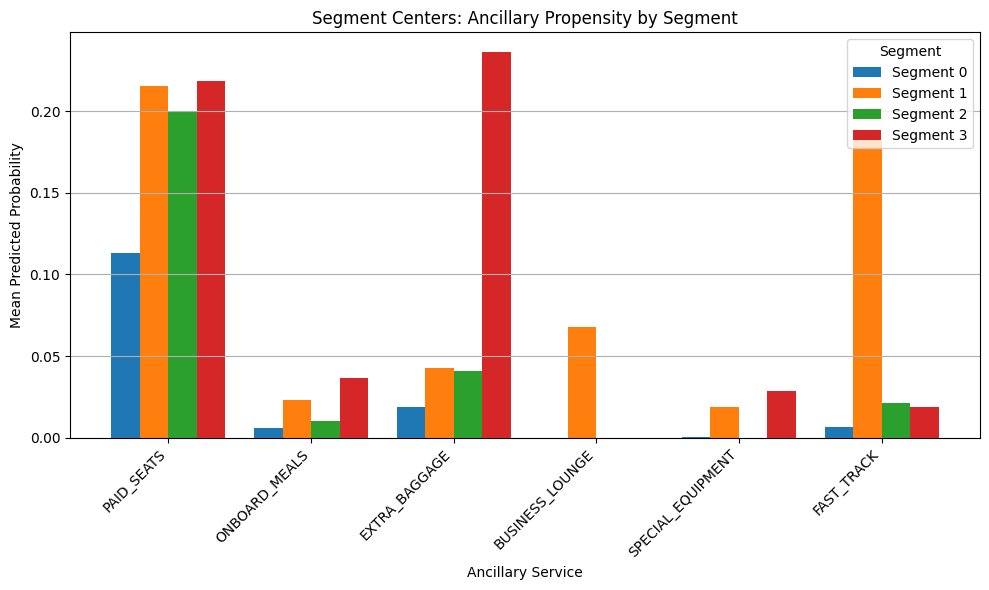

In [88]:
ancillaries = centers.columns.drop('segment')
x = np.arange(len(ancillaries))
width = 0.8 / len(centers)  # total bar width spread equally

plt.figure(figsize=(10, 6))
for idx, row in centers.iterrows():
    plt.bar(x + idx * width, row[ancillaries], width, label=f"Segment {int(row['segment'])}")

plt.xlabel('Ancillary Service')
plt.ylabel('Mean Predicted Probability')
plt.title('Segment Centers: Ancillary Propensity by Segment')
plt.xticks(x + width * (len(centers)-1) / 2, ancillaries, rotation=45, ha='right')
plt.legend(title='Segment', loc='upper right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

**Segment 0 (35 % of users)** has generally low propensities: they only show a modest (\~11 %) chance of buying Paid Seats and barely register elsewhere (all other ancillaries are under \~2 %). In short, these are mostly “no-frills” browsers who rarely add extras.

**Segment 1 (11 %)** stands out with high interest in three services: Paid Seats (\~21 % chance), Fast Track (\~18 %), and Business Lounge (\~7 %). They also have a small (\~4 %) tendency toward Extra Baggage and (\~2 %) toward Special Equipment. This segment appears to be premium-minded travelers who frequently buy multiple ancillaries.

**Segment 2 (50 %)** is the largest group but shows only a moderate (\~20 %) likelihood of purchasing Paid Seats; all other propensities (Fast Track, Extra Baggage, etc.) stay below \~2 %. These users occasionally upgrade seats but rarely buy other extras.

**Segment 3 (3 %)** is small but has the highest Extra Baggage propensity (\~24 %) and a strong (\~22 %) Paid Seats rate. They also show nonzero (though smaller) chances for Business Lounge (\~24 %), Onboard Meals (\~4 %), and Special Equipment (\~3 %). These are heavy-spender travelers focused mostly on checked-bag upgrades but often also taking other premium services.

In [79]:
df_prob = pd.DataFrame(test_predicted_probs, columns=ancillaries, index=y_test.index)

#### User segmentation using GaussianMixture clustering

In [80]:
from sklearn.mixture import GaussianMixture

n_segments = 4 # Economy, Premium Economy, Business and First Class
gmm = GaussianMixture(n_components=n_segments, random_state=42)
df_prob['segment'] = gmm.fit_predict(df_prob[ancillaries])

segment_sizes = (
    df_prob['segment']
      .value_counts()
      .sort_index()
      .rename_axis('segment')
      .reset_index(name='size')
)
centers = (
    pd.DataFrame(gmm.means_, columns=ancillaries)
      .reset_index()
      .rename(columns={'index': 'segment'})
)

/Users/porimolchandro/Work/UW/4th-semester/UB/LOT/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/porimolchandro/Work/UW/4th-semester/UB/LOT/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/porimolchandro/Work/UW/4th-semester/UB/LOT/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/porimolchandro/Work/UW/4th-semester/UB/LOT/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/porimolchandro/Work/UW/4th-semester/UB/LOT/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/porimolchandro/Work/UW/4

In [81]:
segment_sizes

,segment,size
0,0,3103
1,1,38
2,2,1853
3,3,388


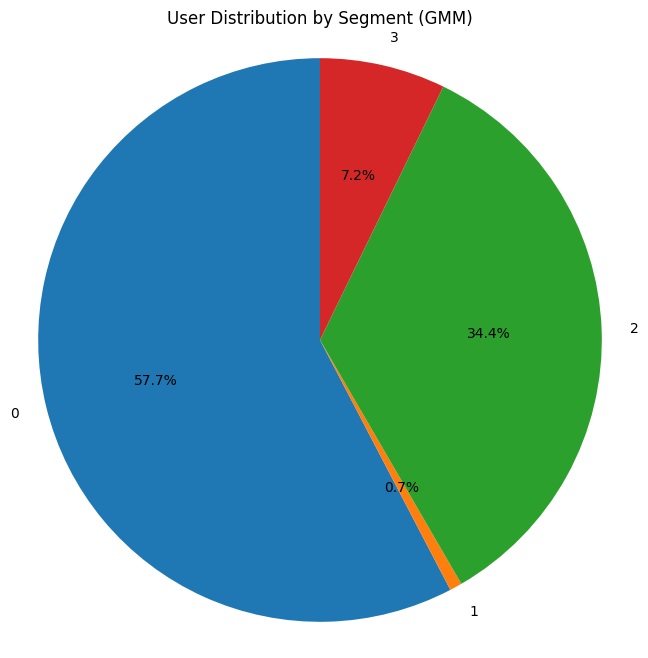

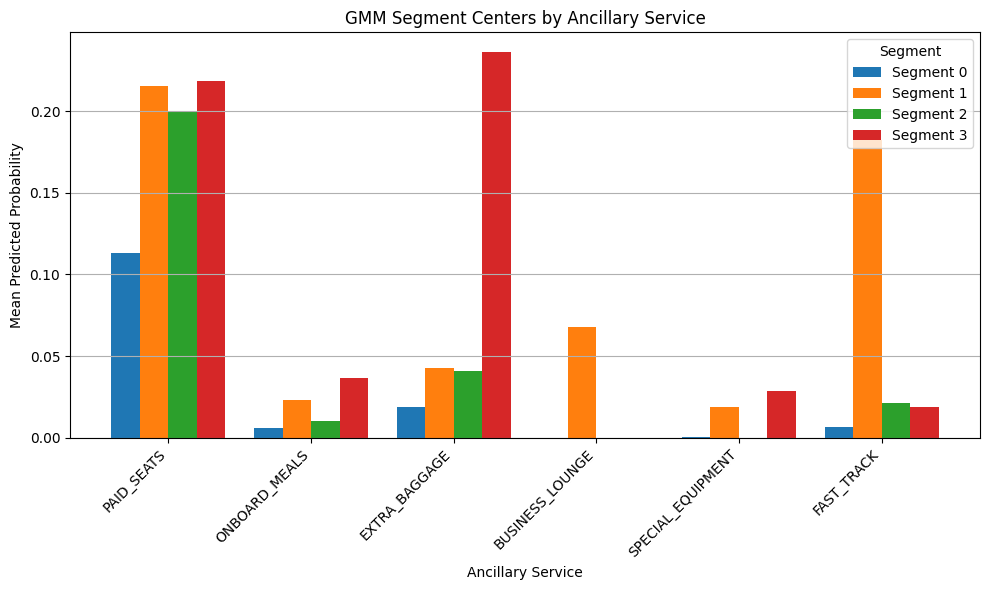

In [82]:
plt.figure(figsize=(8, 8))
plt.pie(
    segment_sizes['size'],
    labels=segment_sizes['segment'],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('User Distribution by Segment (GMM)')
plt.axis('equal')
plt.show()

x = np.arange(len(ancillaries))
width = 0.8 / n_segments

plt.figure(figsize=(10, 6))
for idx, row in centers.iterrows():
    plt.bar(
        x + idx * width,
        row[ancillaries],
        width,
        label=f"Segment {int(row['segment'])}"
    )
plt.xlabel('Ancillary Service')
plt.ylabel('Mean Predicted Probability')
plt.title('GMM Segment Centers by Ancillary Service')
plt.xticks(
    x + width * (n_segments - 1) / 2,
    ancillaries,
    rotation=45,
    ha='right'
)
plt.legend(title='Segment', loc='upper right')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

##### Pie chart

The pie chart shows how users are split into four Gaussian‐Mixture clusters:

* **Cluster 0 (≈57.7 %)** is by far the largest group, containing over half of all users.
* **Cluster 2 (≈34.4 %)** makes up about one‐third of the population.
* **Cluster 3 (≈7.2 %)** is a smaller segment.
* **Cluster 1 (≈0.7 %)** is tiny, representing under 1 % of users.


##### Bar chart

The bar chart shows, for each of the four Gaussian‐Mixture segments, the average likelihood of buying each ancillary service:

* **Segment 0 (57.7 % of users)** has generally low propensities: about **11 %** chance of buying Paid Seats, and almost zero chance for everything else (all under **2 %**). They’re primarily “no‐extras” travelers.

* **Segment 2 (34.4 %)** looks very similar to Segment 0: roughly **20 %** chance of Paid Seats, negligible for other ancillaries. They mainly purchase seats and almost nothing else.

* **Segment 1 (0.7 %)** is a tiny, high‐value group:

  * **Fast Track** (\~18 %) and **Paid Seats** (\~21 %) are their top two choices.
  * They have a moderate **Business Lounge** propensity (\~7 %) and a small (\~4 %) chance of grabbing Extra Baggage or Special Equipment.
    This is clearly a premium segment that buys multiple add-ons.

* **Segment 3 (7.2 %)** is also small but very baggage‐focused:

  * Nearly **24 %** chance of Extra Baggage and **22 %** chance of Paid Seats.
  * They also show some interest in Business Lounge (\~24 %) and smaller (\~4 %) likelihoods for Onboard Meals and Special Equipment.
    In short, these travelers frequently check extra bags (and often buy seats or lounge access).

## Touchpoint-Based Ancillary Service Recommendations

<img src="images/touchpoints.png" alt="Touchpoint-Based Ancillary Service Recommendations" title="Touchpoint-Based Ancillary Service Recommendations" width="1000"/>

To maximize upselling potential and improve personalization throughout the customer journey, we recommend tailoring ancillary service suggestions based on user behavioral segments and specific journey touchpoints. The following actions are proposed:

**Booking Process**

- PAID_SEATS: Recommend to all user segments (strong overall demand).

- EXTRA_BAGGAGE: Target Upsell-Prone and Heavy Buyers.

- BUSINESS_LOUNGE + PAID_SEATS: Promote as a “Premium Pack” to Upsell-Prone users.

- FAST_TRACK: Offer to Upsell-Prone segment.

**Check-in**

- ONBOARD_MEALS: Recommend to Upsell-Prone segment.

- SPECIAL_EQUIPMENT: Suggest only if applicable, primarily to premium segments.

- FAST_TRACK: Show to users from Upsell-Prone segment with moderate-to-high interest.

**Pre-trip Communication**

- Send reminders about baggage upgrades to Budget-Focused and Balanced Buyers.

- Promote high-value bundles (“Premium Pack”) to Upsell-Prone travelers.

**Post-trip Engagement**

- Offer personalized promotions on ancillary services not purchased during the last trip.

- Encourage repeat purchases and customer loyalty through “next trip perks” based on prior behavior.

This approach allows LOT to engage customers at multiple decision points, delivering timely and relevant offers that enhance the travel experience while increasing ancillary revenue.

## Business Impact & Key Findings

<img src="images/business_impact.png" alt="Business Impact of Ancillary Service Recommendations" title="Business Impact of Ancillary Service Recommendations" width="1000"/>

Implementing personalized recommendations based on user behavior improves ancillary sales and customer satisfaction. Segmenting users enables LOT to deliver the right offers at the right time, boosting conversion and revenue.

## Conclusion

This project demonstrates the effectiveness of personalized recommendation systems for promoting ancillary services in the airline industry. By analyzing customer behavior and segmenting users into actionable profiles, we were able to tailor service recommendations across key touchpoints such as booking, check-in, and post-trip engagement.

The results show that services like **PAID_SEATS** and **EXTRA_BAGGAGE** have the highest potential for upselling, especially among segments identified as Upsell-Prone and Heavy Buyers. Implementing such a targeted approach can significantly increase ancillary revenue, improve customer experience, and support LOT in delivering more relevant and timely offers throughout the customer journey.